In [1]:
#| echo: false
import warnings
import astropy.units as u
import matplotlib.pyplot as plt
from mocksipipeline.instrument.configuration import moxsi_cdr
import numpy as np

warnings.filterwarnings('ignore',)

color_palette = {f'filtergram_{i+1}_0':c for i,c in enumerate(["#0A9F9D", "#CEB175", "#E54E21", "#6C8645",])}
for aperture in ['slot','pinhole']:
    for i in range(-11,12):
        if i == 0:
            _c = 'k'
        elif abs(i)==11:
            _c = 'm'
        else:
            _c = f'C{abs(i)-1}'
        color_palette[f'spectrogram_{aperture}_{i}'] = _c

The effective area of MOXSI, including both the dispersed images as well as the filtergrams, as a function of wavelength, $\lambda$, is given by,

$$
A_{eff}(\lambda) = A_{geo}F(\lambda)Q(\lambda)G(\lambda)\quad[\mathrm{cm}^2]
$$
where,
- $A_{geo}$ is the geometrical collecting area of the aperture
- $F(\lambda)$ is the combined transmission of the filters
- $Q(\lambda)$ is the quantum efficiency of the detector
- $G(\lambda)$ is the efficiency of the transmission grating

Because the quantum efficiency is a property of the detector and all images are exposed on the same detector, the quantum efficiency, $Q(\lambda)$, is the same for all filtergrams and dispersed images. In all cases, $Q(\lambda)$ is modeled as the transmission through 50 Å of SiO$_2$ and the absorption of 10 $\mu$m of Si,

$$
Q(\lambda) = F_{SiO_2}(\lambda,d=50\,\mathrm{Å})(1 - F_{Si}(\lambda,d=10\,\mu\mathrm{m}))
$$

where $d$ indicates the thickness of each layer. All other terms in the effective area vary by component and are discussed more fully below.

## Filtergrams

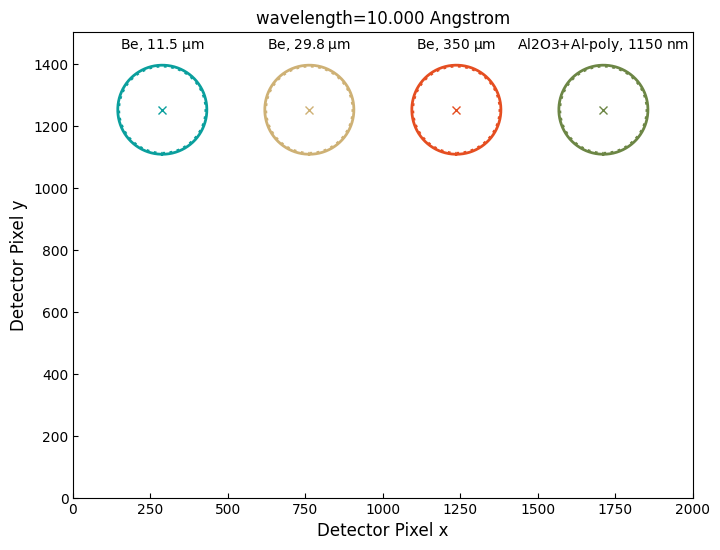

In [2]:
#| echo: false
#| label: filtergram-layout
moxsi_cdr[:4].plot_detector_layout(figsize=(8,8),wavelength=10*u.AA,colors=color_palette)

For the filtergram images, light enters through the circular pinhole aperture with a diameter of 44 $\mu$m and is exposed directly onto the detector *without* passing through a diffraction grating such that $G(\lambda)=1$. In the first three filtergrams, the filter transmission is due to transmission through a layer of Be of the indicated thickness (see @filtergram-layout ). In the case of the fourth channel, "Al-poly", the transmission is given as the combination of the transmission through AlO, Al, and polymide ("poly"),

$$
F_{\mathrm{Al-poly}}(\lambda) = F_{\mathrm{AlO}}(\lambda,d=7.5\,\mathrm{nm})F_{\mathrm{Al}}(\lambda,d=142.5\,\mathrm{nm})F_{\mathrm{poly}}(\lambda,d=1\,\mu\mathrm{m}).
$$

The resulting effective areas of all four filtergrams are shown in @filtergram-ea.

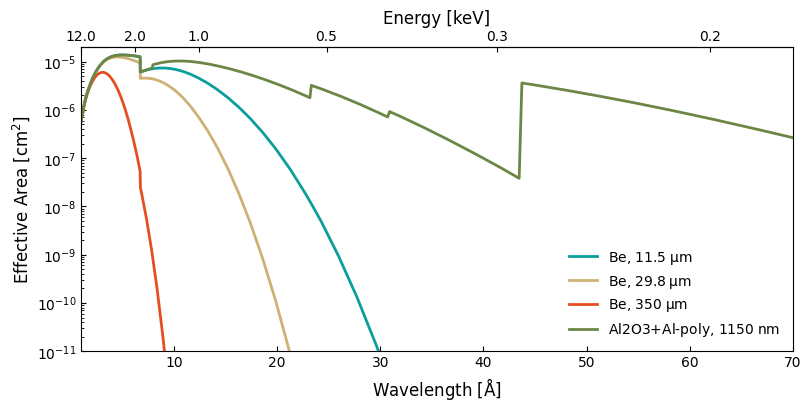

In [3]:
#| echo: false
#| label: filtergram-ea
figsize = (8,4)
wavelengths = np.arange(0, 80, 0.055/2/12) * u.AA
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot()
for chan in moxsi_cdr[:4]:
    chan.wavelength = wavelengths
    ax.plot(chan.wavelength, chan.effective_area,
            color=color_palette[f'{chan.name}_{chan.spectral_order}'],
            label=chan.filter_label)

ax.set_yscale('log')
ax.set_xlim(1,70)
ax.set_ylim(1e-11,2e-5)
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('Effective Area [cm$^2$]')
wave_to_energy = lambda x: u.Quantity(x, 'AA').to_value('keV', equivalencies=u.equivalencies.spectral())
energy_to_wave = lambda x: u.Quantity(x, 'keV').to_value('AA', equivalencies=u.equivalencies.spectral())
secax = ax.secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
secax.set_xlabel('Energy [keV]')
secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
ax.legend(ncol=1, loc=4)

## Dispersed Images

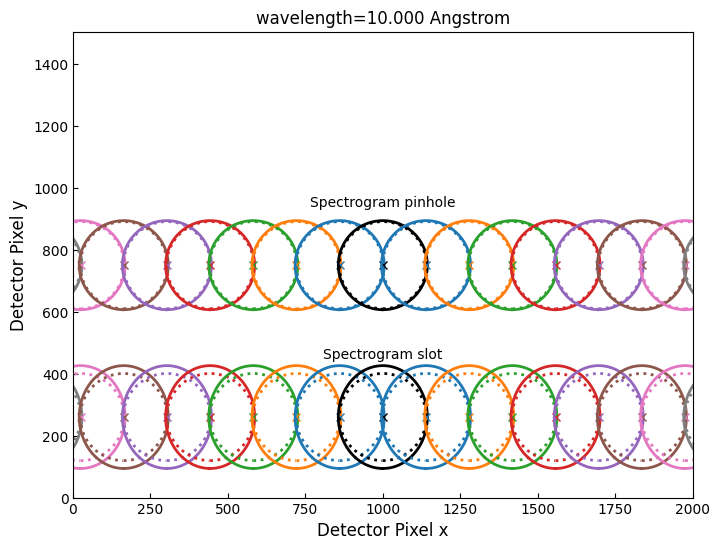

In [4]:
#| echo: false
#| label: dispersed-layout
moxsi_cdr[4:].plot_detector_layout(figsize=(8,8),wavelength=10*u.AA,colors=color_palette)

For the dispersed images, light passes through the aperture and is dispersed onto the detector by a diffraction grating. The gratings used for MOXSI are heritage Chandra HETG gratings. We retrieve the grating efficiencies from the [Chandra calibration database](https://cxc.cfa.harvard.edu/caldb/about_CALDB/directory.html). Specifically, we use the file `hetgD1996-11-01greffpr001N0007.fits`. These files provide the grating efficiency for spectral orders ranging from -11 to +11. @grating-efficiency shows the grating efficiency, $G(\lambda)$ as a function of $\lambda$ for spectral orders ranging from 0 to +12.

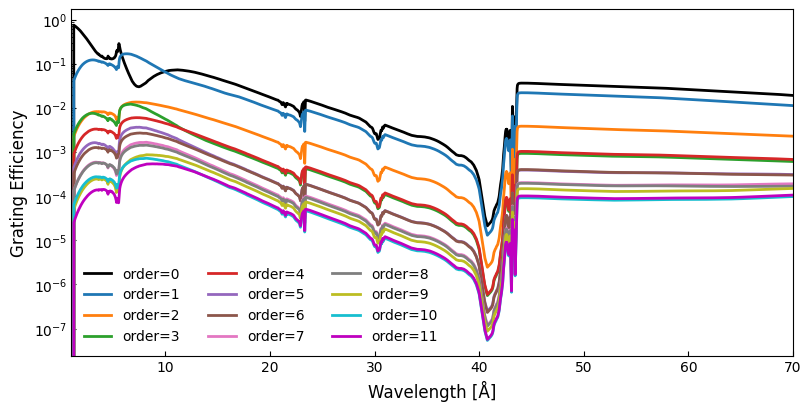

In [5]:
#| echo: false
#| label: grating-efficiency
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot()
for i in range(12):
    chan = moxsi_cdr[f'spectrogram_pinhole_{i}']
    chan.wavelength = wavelengths
    ax.plot(chan.wavelength, chan.grating_efficiency,
            color=color_palette[f'{chan.name}_{chan.spectral_order}'],
            label=f'order={i}')
ax.set_yscale('log')
ax.set_xlim(1,70)
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Grating Efficiency')
ax.legend(loc=3,ncol=3)

The filter transmission is due to transmission through 7.5 nm of AlO and 142.5 nm  of Al,

$$
F_{\mathrm{dispersed}}(\lambda) = F_{\mathrm{AlO}}(\lambda,d=7.5\,\mathrm{nm})F_{\mathrm{Al}}(\lambda,d=142.5\,\mathrm{nm})
$$

### Pinhole

In the case of the pinhole dispersed image, light passes through a circular pinhole with a diameter of 44 $\mu$m. The effective area is shown in @pinhole-dispersed-ea.

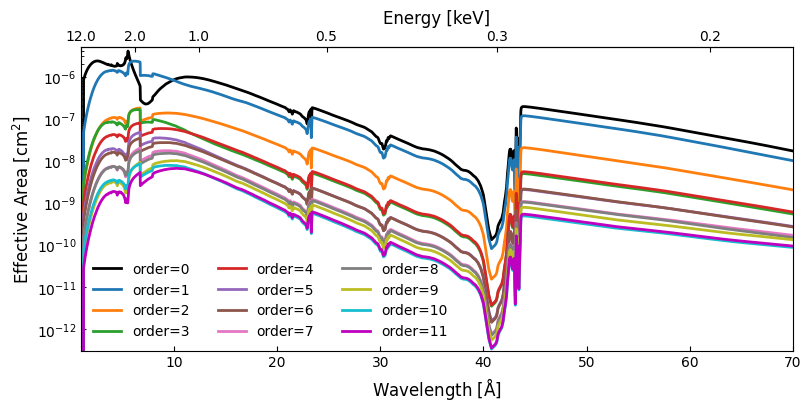

In [6]:
#| echo: false
#| label: pinhole-dispersed-ea
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot()
for chan in moxsi_cdr[15:27]:
    chan.wavelength = wavelengths
    ax.plot(chan.wavelength, chan.effective_area,
            color=color_palette[f'{chan.name}_{chan.spectral_order}'],
            label=f'order={chan.spectral_order}')

ax.set_yscale('log')
ax.set_xlim(1,70)
ax.set_ylim(.3e-12,5e-6)
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('Effective Area [cm$^2$]')
secax = ax.secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
secax.set_xlabel('Energy [keV]')
secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
ax.legend(ncol=3, loc=3)

### Slot

In the case of the slot dispersed image, light passes through an aperture with a width of 44 $\mu$m and a height of $\approx355$ $\mu$m such that the collecting area, and thus the effective area, of the slot is $10\times$ that of the pinhole. The shape of the slot aperture is shown in @slot-aperture. The effective area is shown in @slot-dispersed-ea.

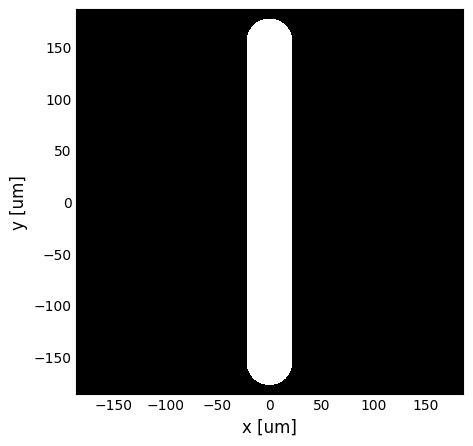

In [7]:
#| echo: false
#| label: slot-aperture
moxsi_cdr[-1].aperture.mask(resolution=0.1*u.micron).plot(add_colorbar=False,
                                                          cmap='Greys',
                                                          aspect=1,
                                                          size=5)

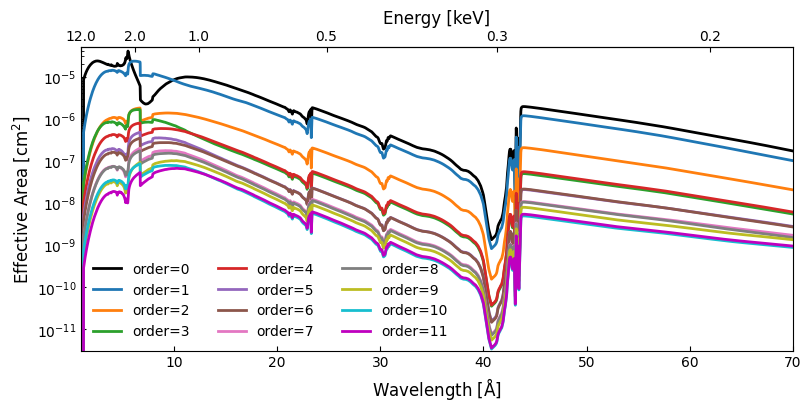

In [8]:
#| echo: false
#| label: slot-dispersed-ea
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot()
for chan in moxsi_cdr[38:]:
    chan.wavelength = wavelengths
    ax.plot(chan.wavelength, chan.effective_area,
            color=color_palette[f'{chan.name}_{chan.spectral_order}'],
            label=f'order={chan.spectral_order}')

ax.set_yscale('log')
ax.set_xlim(1,70)
ax.set_ylim(.3e-11,5e-5)
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('Effective Area [cm$^2$]')
secax = ax.secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
secax.set_xlabel('Energy [keV]')
secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
ax.legend(ncol=3, loc=3)